# Title co-occurrence network analysis

## 1. Creation of dictionary with co-occurences

This code reads an Excel file containing (at least) the following columns: `signature` and `title`.  

First, we create a dictionary (`co_occurrences`) to keep track of co-occurrences. I.e., for each title, the dictionary keeps track of which other titles it co-occurs with in different manuscript signatures, and how many times.


For example, the title *Ortnit* is contained 3 times in a manuscript together with *Virginal*, 2 times with *Eckenlied*, 11 times with *Wolfdietrich*, etc.

```python
'Ortnit': defaultdict(int,
                         {'Virginal': 3,
                          'Eckenlied': 2,
                          'Wolfdietrich': 11,
                          'Der Wunderer': 1,
                          'Laurin': 2,
                          etc.
```

In [204]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict

# read data from Excel
file_path = 'data/xlsx/german.xlsx'

# extract the base name and add .json extension 
# this is done for at the very end of this notebook conveniently saving the graph data with the correct file name
base_filename = file_path.split('/')[-1].split('.')[0]
json_filename = 'data/json/' + base_filename + '.json'

data = pd.read_excel(file_path)

# dictionary to track co-occurrences of titles in different signatures
co_occurrences = defaultdict(lambda: defaultdict(int))

# process the data, tracking co-occurrences of titles in different signatures
for signature, group in data.groupby('signature'):
    # create a set to hold unique titles for this signature
    titles = set()
    for _, row in group.iterrows():
        titles.update(row['title'].split("; "))
    
    # update the co-occurrence count for each pair of titles
    titles = list(titles)
    for i in range(len(titles)):
        for j in range(i + 1, len(titles)):
            co_occurrences[titles[i]][titles[j]] += 1 # this count is later used when creating the edges
            co_occurrences[titles[j]][titles[i]] += 1

The code segment below aims to **visualize the co-occurrence relationships between different text titles across the manuscript signatures**. 

The code iterates through the previously computed co-occurrence dictionary. For every title, it checks if a node for that title exists in the graph; if not, it adds one. For every other title that has co-occurred with the current title, it adds an edge between the two titles with the co-occurrence count as the edge weight. If the edge already exists, it does not add it again, ensuring no duplicate edges are added. 

The edges connecting the nodes, representing co-occurrence relationships, are given a width directly proportional to their co-occurrence counts — the more frequently two titles co-occur across different signatures, the thicker their connecting edge will be.

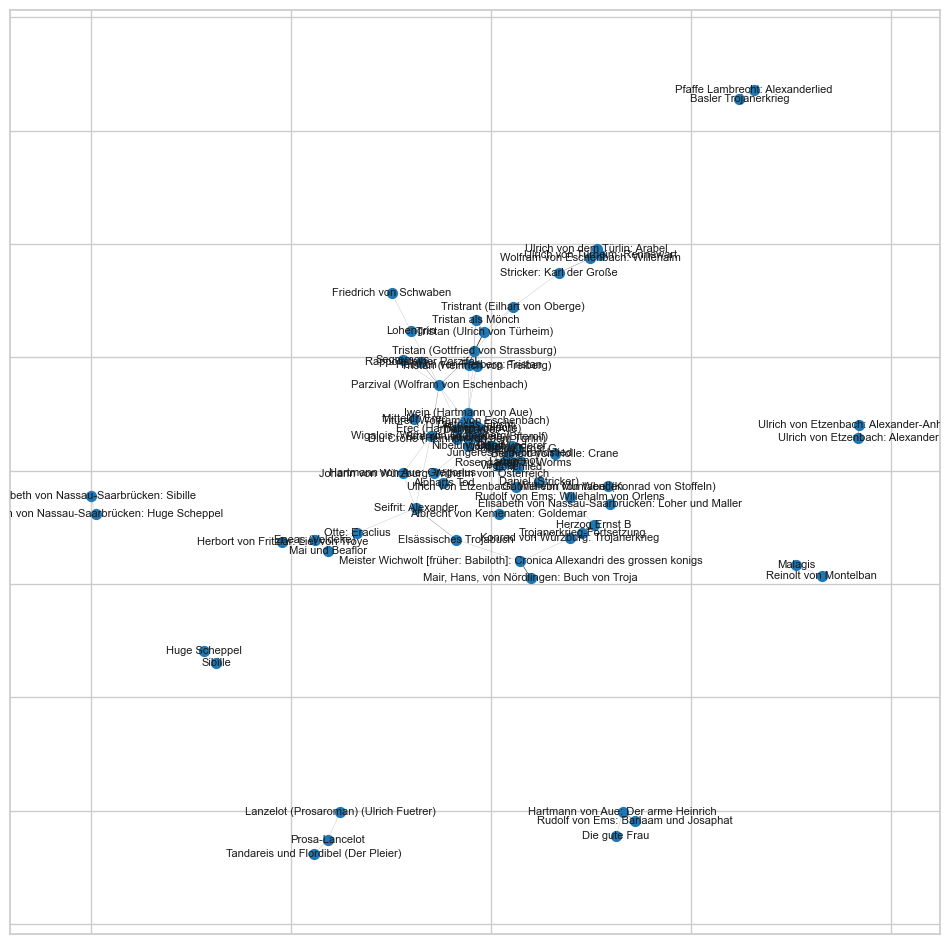

In [205]:
# an empty undirected graph G is initialized using the networkx library
G = nx.Graph()

# add nodes and edges based on co-occurrences
for title, co_occurred_titles in co_occurrences.items():
    G.add_node(title)
    for other_title, count in co_occurred_titles.items():
        if not G.has_edge(title, other_title):
            G.add_edge(title, other_title, weight=count) 

# drawing the graph
pos = nx.spring_layout(G)
plt.figure(figsize=(12, 12))
edges = G.edges(data=True)
nx.draw_networkx_nodes(G, pos, node_size=50)
nx.draw_networkx_labels(G, pos, font_size=8)
# the line below normalizes the weights so that they fall within a decent range for drawing
# so the thickness of each edge in the graph is directly related to the number of times the corresponding titles co-occur across different signatures 
# i.e. the more frequently titles co-occur in manuscripts, the thicker the edge.
nx.draw_networkx_edges(G, pos, edgelist=edges, width=[edata['weight'] / max([edata['weight'] for u, v, edata in edges]) for u, v, edata in edges], alpha=1)
plt.show()

## 2. Analysis of underlying patterns and structures within the network

### 2.1. Centrality Measures in the Network

In this section, we calculate and assign centrality measures to the nodes (titles) of the graph `G`. Centrality measures in network analysis provide insights into the relative importance or influence of nodes within a network. Specifically, we are looking at three types of centrality:

1. **Degree Centrality**: Measures the number of edges connected to a node. For a node $v$, degree centrality is defined as:

    $C_{D}(v) = \frac{\text{degree}(v)}{n-1} $ 

    where $n$ is the total number of nodes in the network. 

    In our graph's context, a title with high degree centrality indicates frequent co-occurrence with many other titles across different signatures.

2. **Eigenvector Centrality**: Considers not only the immediate connections a node has but also the quality (or centrality) of these connections. Essentially, a node is perceived as important if it's connected to other influential nodes. It's a measure of influence. A title with a high eigenvector centrality in our graph indicates that it doesn't just co-occur with many titles, but co-occurs with titles that are themselves frequently interconnected.

3. **Betweenness Centrality**: Indicates the extent to which a node acts as a bridge or intermediary between other nodes. Titles with high betweenness centrality in our network potentially play a vital role in linking clusters of titles that might not directly co-occur but are interconnected via the bridging title.

After calculating each centrality measure, the values are set as node attributes in `G`. As a result, each node now has three new attributes: `degree`, `eigenvector`, and `betweenness`, representing their respective centrality values. This additional information can be beneficial for subsequent analyses or for visualizing the network in ways that highlight the significance or roles of specific nodes.


In [206]:
degree_centrality = nx.degree_centrality(G)
nx.set_node_attributes(G, degree_centrality, 'degree')

eigenvector_centrality = nx.eigenvector_centrality(G)
nx.set_node_attributes(G, eigenvector_centrality, 'eigenvector')

betweenness_centrality = nx.betweenness_centrality(G)
nx.set_node_attributes(G, betweenness_centrality, 'betweenness')

In [207]:
# Get the top 10 nodes by degree centrality
degree_centrality_sorted = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)
print("Top 10 nodes by degree centrality:")
for i, (node, centrality) in enumerate(degree_centrality_sorted[:10]):
    print(f"{i+1}. {node} ({centrality})")

# Get the top 10 nodes by betweenness centrality
betweenness_centrality_sorted = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)
print("\nTop 10 nodes by betweenness centrality:")
for i, (node, centrality) in enumerate(betweenness_centrality_sorted[:10]):
    print(f"{i+1}. {node} ({centrality})")

# Get the top 10 nodes by eigenvector centrality
eigenvector_centrality_sorted = sorted(eigenvector_centrality.items(), key=lambda x: x[1], reverse=True)
print("\nTop 10 nodes by eigenvector centrality:")
for i, (node, centrality) in enumerate(eigenvector_centrality_sorted[:10]):
    print(f"{i+1}. {node} ({centrality})")

Top 10 nodes by degree centrality:
1. Ortnit (0.2602739726027397)
2. Wolfdietrich (0.2465753424657534)
3. Nibelungenlied (0.2054794520547945)
4. Iwein (Hartmann von Aue) (0.2054794520547945)
5. Rosengarten zu Worms (0.1643835616438356)
6. Virginal (0.1506849315068493)
7. Laurin (0.1506849315068493)
8. Dietrichs Flucht (0.1506849315068493)
9. Rabenschlacht (0.1506849315068493)
10. Titurel (Wolfram von Eschenbach) (0.1506849315068493)

Top 10 nodes by betweenness centrality:
1. Iwein (Hartmann von Aue) (0.20972222222222225)
2. Tristan (Gottfried von Strassburg) (0.138603500761035)
3. Wigalois (Wirnt von Grafenberg) (0.12536832142996526)
4. Parzival (Wolfram von Eschenbach) (0.11578513444951802)
5. Seifrit: Alexander (0.11275416617882374)
6. Rudolf von Ems: Willehalm von Orlens (0.11083791905709713)
7. Ortnit (0.09983071849510199)
8. Nibelungenlied (0.09286919954728166)
9. Wolfdietrich (0.09114223549155051)
10. Tristrant (Eilhart von Oberge) (0.0806697108066971)

Top 10 nodes by eigenvect

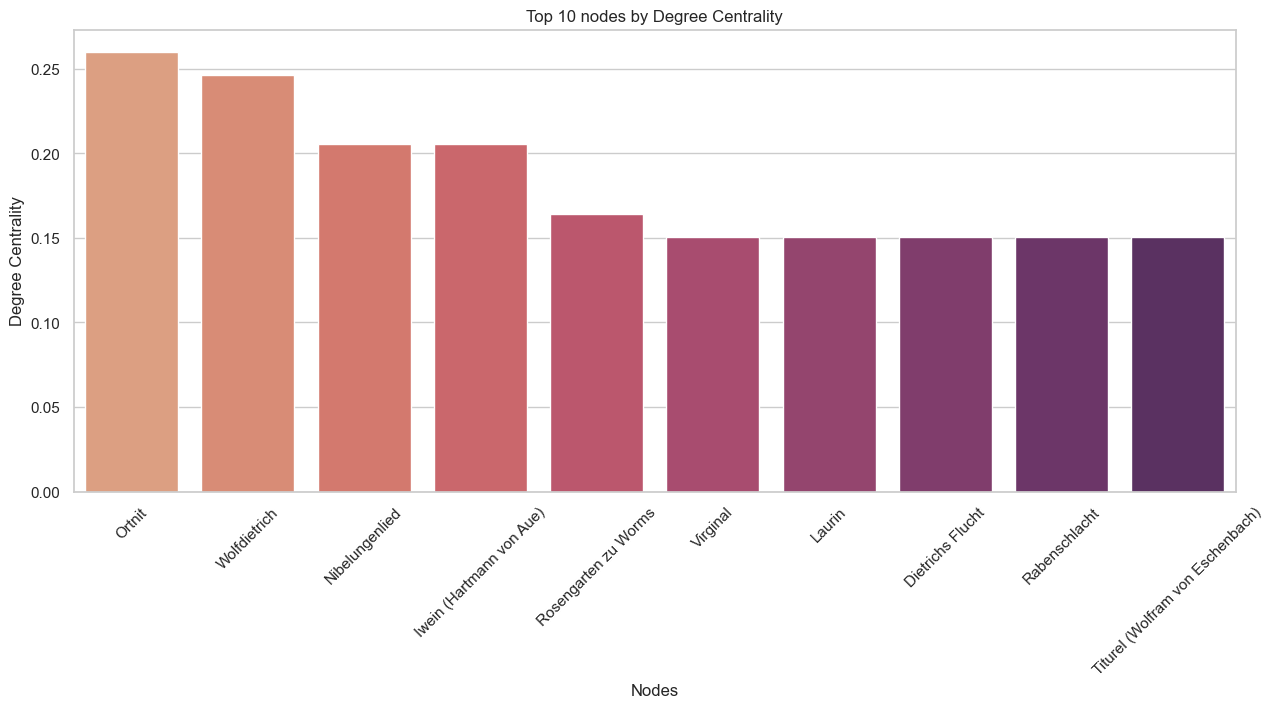

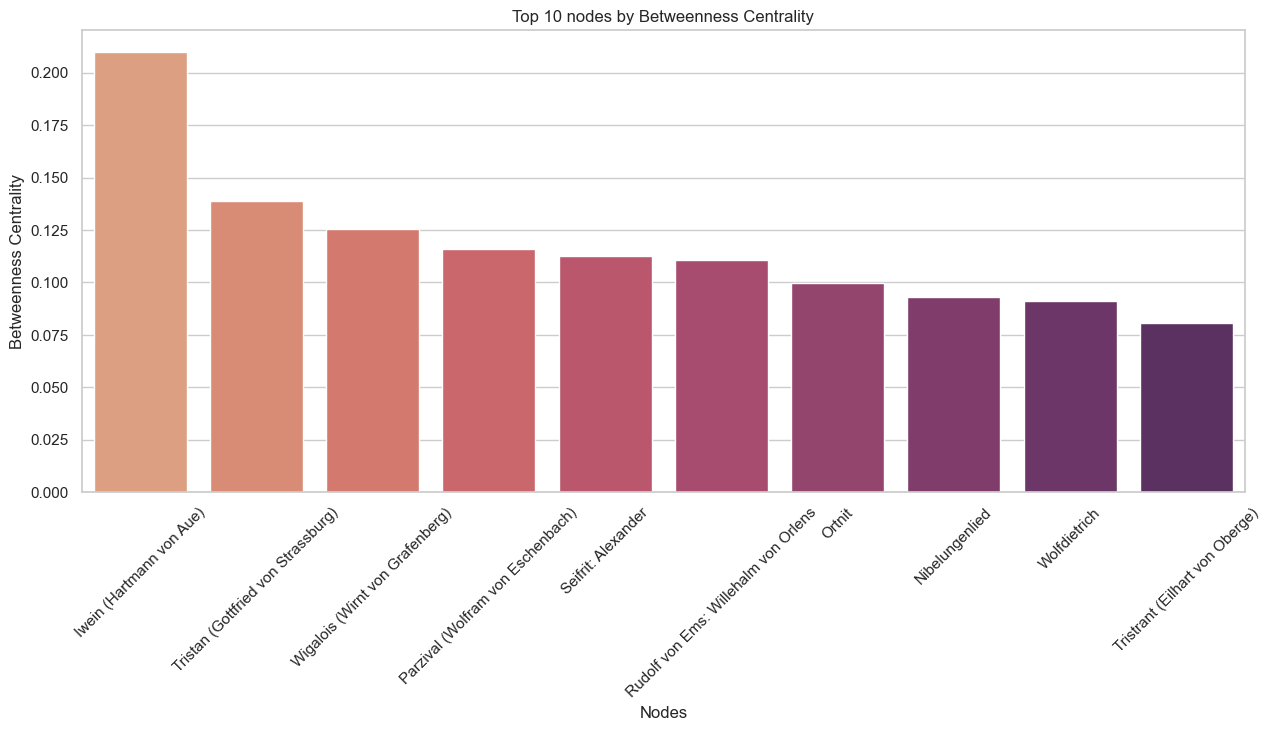

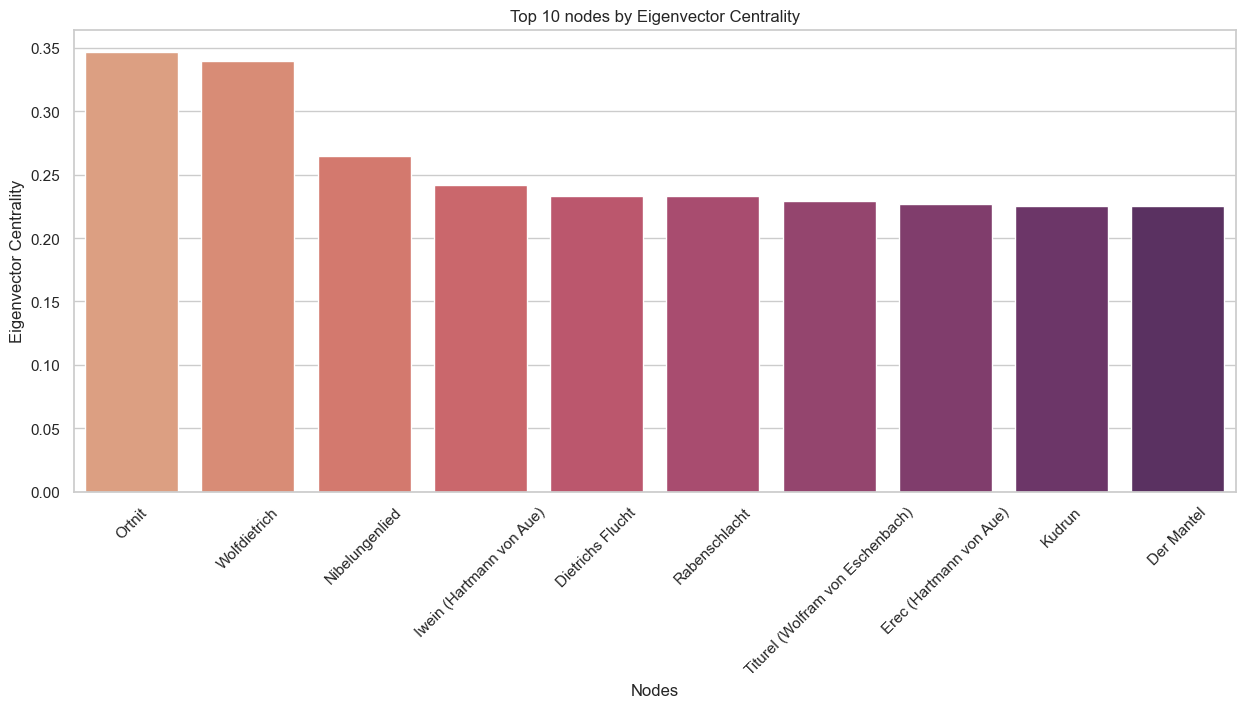

In [208]:
import seaborn as sns
import numpy as np

sns.set(style="whitegrid")

# function to plot centralities
def plot_centrality(sorted_centrality, centrality_name):
    nodes = [node for node, _ in sorted_centrality]
    values = [value for _, value in sorted_centrality]

    # normalize the values for color mapping
    colors = sns.color_palette("flare", len(values)).as_hex()

    plt.figure(figsize=(15, 6))
    sns.barplot(x=nodes, y=values, palette=colors)
    plt.title(f'Top 10 nodes by {centrality_name}')
    plt.xlabel('Nodes')
    plt.ylabel(centrality_name)
    plt.xticks(rotation=45)
    plt.show()

# Get the top 10 nodes by degree centrality and plot
degree_centrality_sorted = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
plot_centrality(degree_centrality_sorted, 'Degree Centrality')

# Get the top 10 nodes by betweenness centrality and plot
betweenness_centrality_sorted = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
plot_centrality(betweenness_centrality_sorted, 'Betweenness Centrality')

# Get the top 10 nodes by eigenvector centrality and plot
eigenvector_centrality_sorted = sorted(eigenvector_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
plot_centrality(eigenvector_centrality_sorted, 'Eigenvector Centrality')


The provided code block aims to visually represent the relationship between the three different centrality measures—Degree Centrality, Betweenness Centrality, and Eigenvector Centrality—for each node in the network.

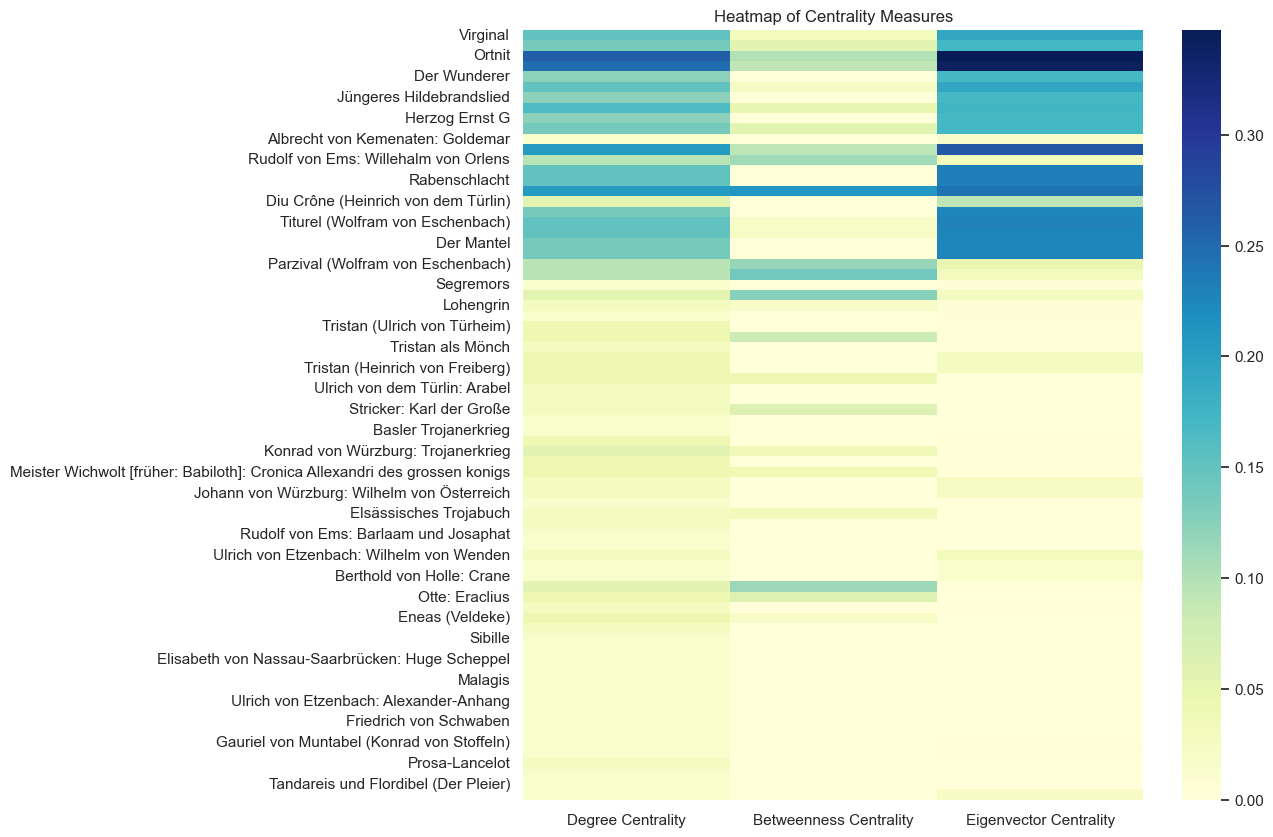

In [209]:
# Create a DataFrame for the heat map
heatmap_data = pd.DataFrame({
    'Degree Centrality': degree_centrality,
    'Betweenness Centrality': betweenness_centrality,
    'Eigenvector Centrality': eigenvector_centrality
})

# Plotting the heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(heatmap_data, cmap='YlGnBu')
plt.title("Heatmap of Centrality Measures")
plt.show()


### 2.2. Community Detection

We'll use the Louvain method for community detection. This method can be used to detect communities in large networks. The method uncovers hierarchies of communities and is based on modularity optimization.

In [210]:
# pip install python-louvain
from community import community_louvain

communities = community_louvain.best_partition(G)
nx.set_node_attributes(G, communities, 'community')

## 3. Enhanced Visualization

Now we can use the attributes we calculated above to create an enhanced visualization. We can use 
- **node size** to represent **degree centrality** (or another centrality measure we calculated before)
- **node color** to represent the **community**


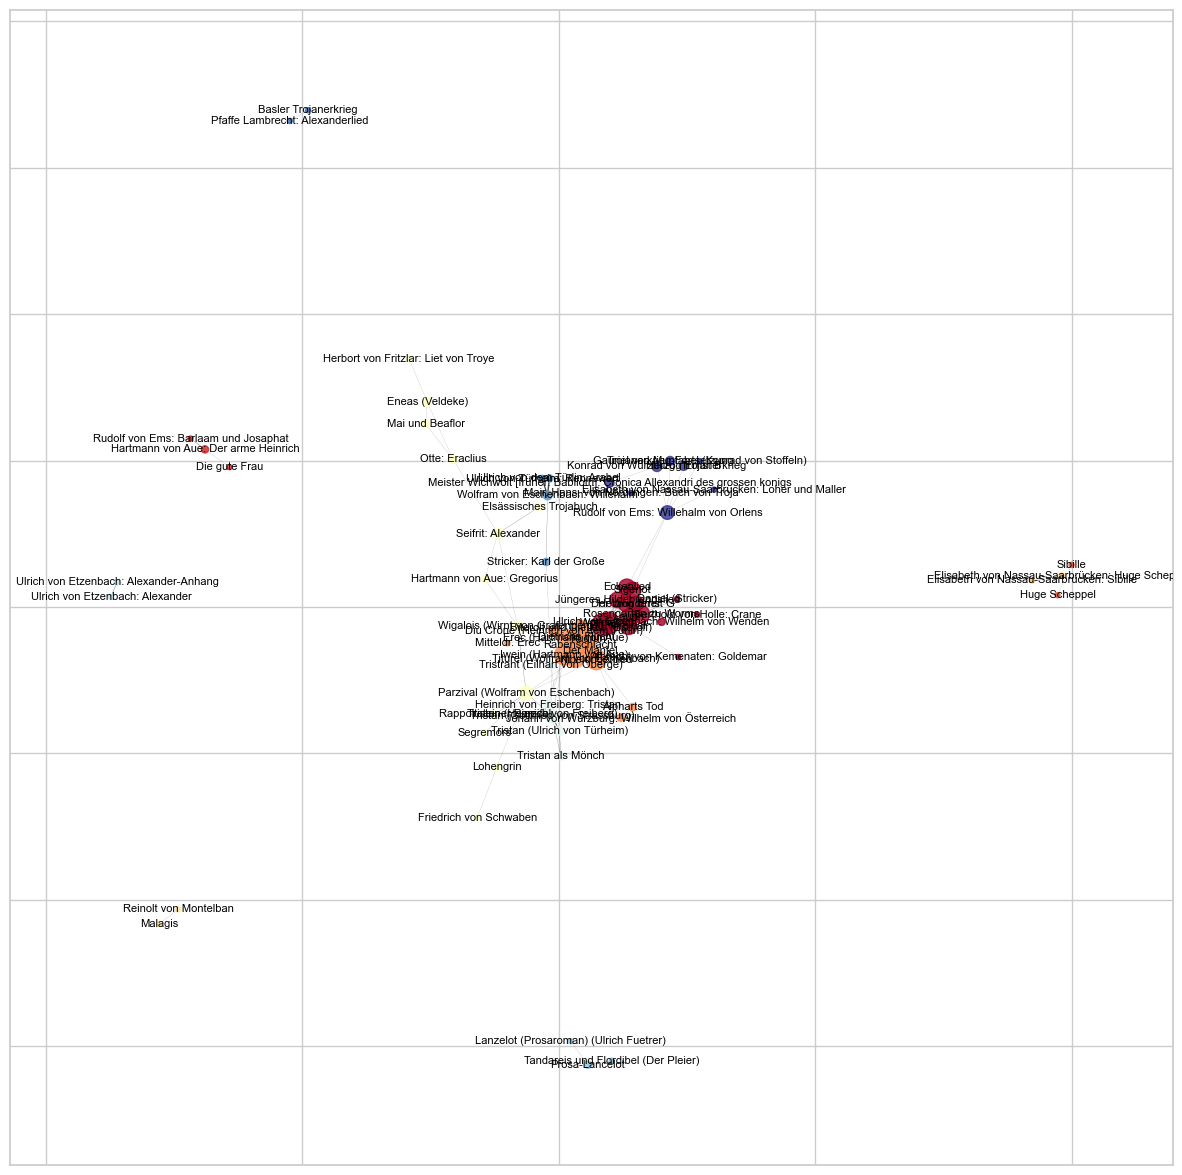

In [211]:
plt.figure(figsize=(15, 15))

# position
pos = nx.spring_layout(G)

# community colors
community_colors = [communities[node] for node in G.nodes()]

# node sizes based on degree centrality
node_sizes = [degree_centrality[node] * 1000 for node in G.nodes()]

# draw nodes
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, cmap=plt.cm.RdYlBu, node_color=community_colors, alpha=0.8)

# draw edges
nx.draw_networkx_edges(G, pos, width=[edata['weight'] / max([edata['weight'] for u, v, edata in edges]) for u, v, edata in edges], alpha=0.8)

# add labels (these are the titles)
nx.draw_networkx_labels(G, pos, font_size=8, font_color='black')
#plt.axis('off')

plt.show()

We can also recreate this plot **interactively**, retaining the node colors based on community, size based on `degree_centrality` (or: `eigenvector_centrality`, or `betweenness_centrality`) and adding labels.

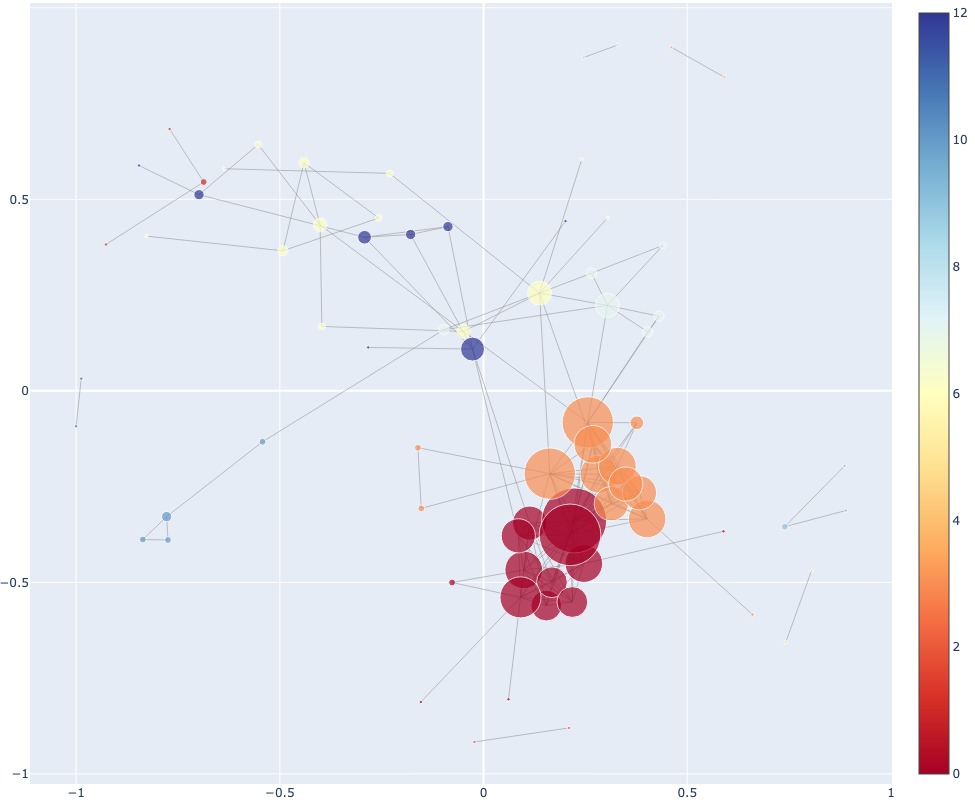

In [212]:
# position with modified spring layout
pos = nx.spring_layout(G, k=1, iterations=150) # increase k for more space between nodes, adjust iterations as needed

# node sizes based on degree centrality, with scaling
node_sizes = [degree_centrality[node] * 250 for node in G.nodes()] # Nodes scaled up by a factor for better visualization

# edge trace
edge_trace = go.Scatter(
    x=[],
    y=[],
    line=dict(width=0.5, color='#888'),
    mode='lines',
)

for edge in G.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_trace['x'] += tuple([x0, x1, None])
    edge_trace['y'] += tuple([y0, y1, None])

# node trace
node_trace = go.Scatter(
    x=[pos[node][0] for node in G.nodes()],
    y=[pos[node][1] for node in G.nodes()],
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        colorscale='RdYlBu',
        size=node_sizes,
        color=community_colors,
    ),
    text=[f'{node}<br>Community: {communities[node]}' for node in G.nodes()],
)

# create figure with increased width and height
fig = go.Figure(data=[edge_trace, node_trace],
                layout=go.Layout(
                    showlegend=False,
                    hovermode='closest',
                    margin=dict(b=0, l=0, r=0, t=0),
                    width=1000, # Adjust as needed
                    height=800, # Adjust as needed
                ))

# show figure
fig.show()

... and we can even create an **interactive 3D plot** if we want to be really fancy!

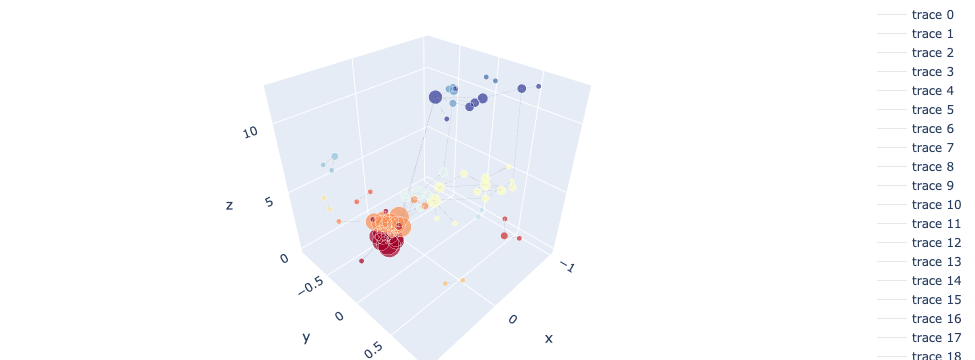

In [213]:
from plotly import graph_objects as go

# scale node sizes using a nonlinear function (sqrt)!!
max_size = 50
node_sizes_scaled = [max_size * np.sqrt(degree_centrality[node]) for node in G.nodes()]

# create a 3D position using the 2D spring layout
pos_3d = {node: (x, y, communities[node]) for node, (x, y) in pos.items()}

# extract coordinates
x, y, z = zip(*pos_3d.values())

# create 3D scatter plot for nodes
node_trace = go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers',
    marker=dict(
        size=node_sizes_scaled,
        color=community_colors,
        colorscale='RdYlBu',
    ),
)

# create lines for edges
edge_trace = []
for edge in G.edges():
    x0, y0, z0 = pos_3d[edge[0]]
    x1, y1, z1 = pos_3d[edge[1]]
    edge_trace.append(
        go.Scatter3d(
            x=[x0, x1, None],
            y=[y0, y1, None],
            z=[z0, z1, None],
            mode='lines',
            line=dict(width=0.2, color='#888'),
        )
    )

# create the figure
fig = go.Figure(data=[*edge_trace, node_trace])

# Define layout
fig.update_layout(
    scene=dict(
        xaxis=dict(nticks=4),
        yaxis=dict(nticks=4),
        zaxis=dict(nticks=4),
    ),
    margin=dict(r=0, l=0, b=0, t=0),
)

fig.show()

## 4. Network Graph Data Extraction and Serialization

The code below is crafted to process a network graph $G$ and format its data in a structure that can be utilized in various applications, particularly **for D3.js visualizations**.

### Node extraction:
- Every node's details from the graph `G` are extracted. Three attributes are primarily stored for each node:
    - `id`: The name of the node.
    - `group`: The community the node belongs to.
    - `size`: Scaled by the node's degree.

### Links (Edges) extraction:
- Information about each edge in the graph `G` is extracted. Three main attributes are stored for every edge:
    - `source`: The starting node of the edge.
    - `target`: The ending node of the edge.
    - `value`: The weight or intensity of the connection.

### Data consolidation and serialization:
- The extracted nodes and links (edges) details are combined into a single dictionary named `graph_data`.
- This `graph_data` dictionary is then sorted based on the nodes' group property.
- Once sorted, the data is serialized and converted to a JSON format. Proper indentation is applied to ensure that the output is readable.

In [215]:
import json

# extract nodes and links (edges) in the desired format
nodes = []
links = []

# extract nodes
for node, data in G.nodes(data=True):
    nodes.append({
        "id": node,
        "group": data['community'],
        "size": data['degree'] * 1000  # adjust scaling as per your requirements
    })

# extract links (edges)
for u, v, data in G.edges(data=True):
    links.append({
        "source": u,
        "target": v,
        "value": data['weight']
    })

# combine nodes and links in a dictionary
graph_data = {
    "nodes": nodes,
    "links": links
}

# sort nodes by the group property
sorted_nodes = sorted(graph_data['nodes'], key=lambda x: x['group'])
graph_data['nodes'] = sorted_nodes

# convert the sorted data back to JSON
sorted_json = json.dumps(graph_data, indent=4)

# save to json file
with open(json_filename, 'w') as json_file:
    json_file.write(sorted_json)

print(json.dumps(graph_data, indent=4))

{
    "nodes": [
        {
            "id": "Virginal",
            "group": 0,
            "size": 150.6849315068493
        },
        {
            "id": "Eckenlied",
            "group": 0,
            "size": 136.986301369863
        },
        {
            "id": "Ortnit",
            "group": 0,
            "size": 260.2739726027397
        },
        {
            "id": "Wolfdietrich",
            "group": 0,
            "size": 246.5753424657534
        },
        {
            "id": "Der Wunderer",
            "group": 0,
            "size": 123.2876712328767
        },
        {
            "id": "Laurin",
            "group": 0,
            "size": 150.6849315068493
        },
        {
            "id": "J\u00fcngeres Hildebrandslied",
            "group": 0,
            "size": 123.2876712328767
        },
        {
            "id": "Rosengarten zu Worms",
            "group": 0,
            "size": 164.3835616438356
        },
        {
            "id": "Herzog Ernst 

-----